<a href="https://colab.research.google.com/github/jbhunter52/BTWBResults/blob/master/ExchangeUniverse_Combo_Momentum_Trend_Weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Combining Momentum and Trend Following

In this notebook we combine momentum and trend-following factors together in a single strategy.


## Load libraries and authenticate

In [1]:
# snippet: rw load rwrtools for crypto pod v0.1
if(!require("pacman")) install.packages("pacman")
pacman::p_load_current_gh("RWLab/rwRtools", dependencies = TRUE)
pacman::p_load_current_gh("Robot-Wealth/rsims", dependencies = TRUE)
pacman::p_load(tidyverse, lubridate, purrr, zoo, glue, RcppRoll, tibbletime, Hmisc, Rcpp,httr,jsonlite)

# Set chart options
options(repr.plot.width = 19, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Loading required package: pacman

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘pacman’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



R6           (2.5.0 -> 2.5.1 ) [CRAN]
iterators    (NA    -> 1.0.13) [CRAN]
zoo          (NA    -> 1.8-9 ) [CRAN]
R.methodsS3  (NA    -> 1.8.1 ) [CRAN]
cachem       (1.0.5 -> 1.0.6 ) [CRAN]
openssl      (1.4.3 -> 1.4.4 ) [CRAN]
foreach      (NA    -> 1.5.1 ) [CRAN]
xts          (NA    -> 0.12.1) [CRAN]
R.oo         (NA    -> 1.24.0) [CRAN]
googleAuthR  (NA    -> 1.4.0 ) [CRAN]
doParallel   (NA    -> 1.0.16) [CRAN]
TTR          (NA    -> 0.24.2) [CRAN]
feather      (NA    -> 0.3.5 ) [CRAN]
R.utils      (NA    -> 2.10.1) [CRAN]
googleClo... (NA    -> 0.6.0 ) [CRAN]
✔  checking for file ‘/tmp/Rtmpfqxwc5/remotes417b6277ea/RWLab-rwRtools-0696601/DESCRIPTION’
─  preparing ‘rwRtools’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
   Omitted ‘LazyData’ from DESCRIPTION
─  building ‘rwRtools_0.1.6.tar.gz’
   
textshaping (NA -> 0.3.5) [CRAN]
ragg        (NA -> 1.1.3) [CRAN]
downli

Warning message in i.p(...):
“installation of package ‘textshaping’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘ragg’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘pkgdown’ had non-zero exit status”


✔  checking for file ‘/tmp/Rtmpfqxwc5/remotes41627b749a/Robot-Wealth-rsims-8c16937/DESCRIPTION’
─  preparing ‘rsims’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
     NB: this package now depends on R (>= 3.5.0)
     serialize/load version 3 cannot be read in older versions of R.
     File(s) containing such objects:
       ‘rsims/data/backtest_df.RData’ ‘rsims/data/backtest_df_long.RData’
─  building ‘rsims_0.0.0.9002.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


RcppRoll installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


tibbletime installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘png’, ‘jpeg’, ‘checkmate’, ‘htmlwidgets’, ‘Formula’, ‘latticeExtra’, ‘gridExtra’, ‘htmlTable’, ‘viridis’



Hmisc installed



In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/auth?client_id=603366585132-0l5tra7gl2i20iftqangp7iskte4f3s0.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code



Enter authorization code: 4/1AX4XfWiZb8X5zWq7YhFXx-U5gKgmv0fDSmXS6N7o3acBo9Rk0ZyicVBzlJA


Get ftx.us universe

In [4]:
res = GET('http://ftx.us/api/markets')
json <- fromJSON(content(res, "text"), simplifyVector = TRUE, flatten = TRUE)

ftxus <- json$result %>%
  mutate(token = str_split(name, '/', simplify=TRUE)[,1],
         base = str_split(name, '/', simplify=TRUE)[,2]) %>%
  filter(base %in% c('USD', 'USDT')) %>%
  select(name,token) %>%
  pull(token) %>%
  unique()

length(ftxus)
ftxus

No encoding supplied: defaulting to UTF-8.



[1] 26

[1] "AAVE"  "AUD"   "BAT"   "BCH"   "BRZ"   "BTC"   "CAD"   "CUSDT" "DAI"  
[10] "DOGE"  "ETH"   "EUR"   "GBP"   "GRT"   "LINK"  "LTC"   "MATIC" "MKR"  
[19] "PAXG"  "SOL"   "SUSHI" "TRX"   "UNI"   "USDT"  "WBTC"  "YFI"

Get ftx

In [5]:
res = GET('http://ftx.com/api/markets')
json <- fromJSON(content(res, "text"), simplifyVector = TRUE, flatten = TRUE)

ftx <- json$result %>%
  filter(grepl('/', name),
         !grepl('BEAR', name),
         !grepl('BULL', name),
         !grepl('HALF', name),
         !grepl('HEDGE', name)) %>%
  mutate(token = str_split(name, '/', simplify=TRUE)[,1],
         base = str_split(name, '/', simplify=TRUE)[,2]) %>%
  filter(base %in% c('USD', 'USDT')) %>%
  select(name,token) %>%
  pull(token) %>%
  unique()

length(ftx)
ftx

No encoding supplied: defaulting to UTF-8.



[1] 171

[1] "1INCH"  "AAPL"   "AAVE"   "ABNB"   "ACB"    "AKRO"   "ALCX"   "ALPHA" 
  [9] "AMC"    "AMD"    "AMPL"   "AMZN"   "APHA"   "ARKK"   "ASD"    "AUDIO" 
 [17] "AXS"    "BABA"   "BADGER" "BAL"    "BAND"   "BAO"    "BAT"    "BB"    
 [25] "BCH"    "BILI"   "BITW"   "BNB"    "BNT"    "BNTX"   "BRZ"    "BTC"   
 [33] "BYND"   "C98"    "CAD"    "CEL"    "CGC"    "CHR"    "CHZ"    "CLV"   
 [41] "COIN"   "COMP"   "CONV"   "COPE"   "CQT"    "CREAM"  "CRO"    "CRON"  
 [49] "CRV"    "CUSDT"  "DAI"    "DAWN"   "DENT"   "DKNG"   "DMG"    "DODO"  
 [57] "DOGE"   "EMB"    "ENJ"    "ETH"    "ETHE"   "EUR"    "FB"     "FIDA"  
 [65] "FRONT"  "FTM"    "FTT"    "GBP"    "GBTC"   "GDX"    "GDXJ"   "GLD"   
 [73] "GLXY"   "GME"    "GOOGL"  "GRT"    "GT"     "HGET"   "HMT"    "HNT"   
 [81] "HOLY"   "HOOD"   "HT"     "HUM"    "HXRO"   "JST"    "KIN"    "KNC"   
 [89] "LEO"    "LINA"   "LINK"   "LRC"    "LTC"    "LUA"    "MAPS"   "MATH"  
 [97] "MATIC"  "MEDIA"  "MER"    "MKR"    "MNGO"   "MOB"    "MRNA"   "MSTR"  
[105] "MTA"    "MTL"    "NFLX"   "NIO"    "NOK"    "NVDA"   "OKB"    "OMG"   
[113] "ORBS"   "OXY"    "PAXG"   "PENN"   "PERP"   "PFE"    "PROM"   "PUNDIX"
[121] "PYPL"   "RAMP"   "RAY"    "REEF"   "REN"    "ROOK"   "RSR"    "RUNE"  
[129] "SAND"   "SECO"   "SHIB"   "SKL"    "SLP"    "SLRS"   "SLV"    "SNX"   
[137] "SNY"    "SOL"    "SPY"    "SQ"     "SRM"    "STEP"   "STMX"   "STORJ" 
[145] "SUN"    "SUSHI"  "SXP"    "TLRY"   "TOMO"   "TRU"    "TRX"    "TRYB"  
[153] "TSLA"   "TSM"    "TWTR"   "UBER"   "UBXT"   "UNI"    "USDT"   "USO"   
[161] "WAVES"  "WBTC"   "WRX"    "XAUT"   "XRP"    "YFI"    "YFII"   "ZM"    
[169] "ZRX"    "BVOL"   "IBVOL"

Get binance.us 

In [6]:
res = GET('https://api.binance.us/api/v3/exchangeInfo')
json <- fromJSON(content(res, "text"), simplifyVector = TRUE, flatten = TRUE)

binanceus <- data.frame(symbol=json$symbols$symbol) %>%
  filter(grepl('USD', symbol)) %>%
  mutate(token = str_split(symbol, 'USD', simplify=TRUE)[,1]) %>%
  filter(nchar(token) > 1) %>%
  pull(token) %>%
  unique()

length(binanceus)
binanceus

[1] 69

[1] "BTC"    "ETH"    "XRP"    "BCH"    "LTC"    "BNB"    "ADA"    "BAT"   
 [9] "ETC"    "XLM"    "ZRX"    "LINK"   "RVN"    "DASH"   "ZEC"    "ALGO"  
[17] "IOTA"   "BTCB"   "DOGE"   "WAVES"  "ATOM"   "NEO"    "VET"    "QTUM"  
[25] "NANO"   "ICX"    "ENJ"    "ONT"    "ZIL"    "ZILB"   "BNBB"   "XRPB"  
[33] "ETHB"   "ALGOB"  "XTZ"    "XTZB"   "HBAR"   "HBARB"  "OMG"    "OMGB"  
[41] "MATIC"  "MATICB" "REPB"   "REP"    "EOSB"   "EOS"    "KNC"    "VTHO"  
[49] "COMP"   "MANA"   "HNT"    "MKR"    "DAI"    "ONE"    "BAND"   "STORJ" 
[57] "UNI"    "SOL"    "EGLD"   "PAXG"   "OXT"    "ZEN"    "ONEB"   "FIL"   
[65] "AAVE"   "GRT"    "SUSHI"  "ANKR"   "AMP"

## Load Coinmetrics daily data
> Indented block
Update filter below to select current tickers for an exchange above, currently just FTX, FTX.us, and Binance.us

In [124]:
# snippet: rw crypto quickstart v.0.1
quicksetup(pod = "Crypto", path = ".")
prices <- prices %>% filter(ticker %in% binanceus)

summary(prices)


Set default bucket name to 'crypto_research_pod'



Attempting download of  coinmetrics.csv ...
Transferring coinmetrics.csv ... data is 6.5 Mb please be patient...


2021-08-21 00:53:45 -- Saved coinmetrics.csv to ./coinmetrics.csv (6.5 Mb)



coinmetrics.csv successfully transferred


Rows: 131519 Columns: 4

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ticker
dbl  (2): price_usd, market_cap
date (1): date


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



prices data object transferred and loaded as data.frame to Global Env


    ticker               date              price_usd          market_cap       
 Length:45434       Min.   :2010-07-18   Min.   :    0.00   Min.   :1.777e+05  
 Class :character   1st Qu.:2017-09-26   1st Qu.:    0.32   1st Qu.:2.235e+08  
 Mode  :character   Median :2019-02-21   Median :    4.52   Median :7.714e+08  
                    Mean   :2018-10-15   Mean   :  590.75   Mean   :1.486e+10  
                    3rd Qu.:2020-07-01   3rd Qu.:   85.02   3rd Qu.:4.309e+09  
                    Max.   :2021-08-19   Max.   :63445.64   Max.   :1.185e+12  

In [125]:
prices %>% group_by(date) %>% arrange(date) %>% tail()

ticker,date,price_usd,market_cap
<chr>,<date>,<dbl>,<dbl>
WAVES,2021-08-19,23.8105829,2381058294
XLM,2021-08-19,0.3662543,38618592642
XRP,2021-08-19,1.2232751,122315559131
XTZ,2021-08-19,3.6306489,3108729862
ZEC,2021-08-19,146.9500936,1687316053
ZRX,2021-08-19,1.0188476,1018847566


# Utility Code

In [126]:
create_universe <- function(prices, n=10, min_constituents = 10) {
  # snippet: rw crypto remove stablecoins v0.2
  # Remove stablecoins from data set
  prices <- prices %>% 
    filter(!ticker %in% c('BUSD','DAI','GUSD','HUSD','PAX','SAI','TUSD','USDC','USDK','USDT','USDT_ETH','USDT_OMNI','USDT_TRX', 'XAUT')) 
  # snippet: rw crypto remove duplicates v0.1
  # Remove duplicate protocol coins from data set
  prices <- prices %>% 
    filter(!ticker %in% c('BNB_ETH','LEO_EOS','RENBTC', 'WNXM', 'WETH', 'WBTC'))

  # Get first date where we have min_constituents
  start_date <- prices %>%
    group_by(date) %>%
    summarise(count = n()) %>%
    filter(count >= min_constituents) %>%
    summarise(mindate = min(date)) %>%
    pull(mindate)

  # Flag universe consitutents
  # For a given ticker/date observation, set is_index to TRUE if:
  #    - the asset was in the top 10 coins by market cap the day before
  #    - the date is on or after the date when we have min_consituents assets in our dataset
  prices %>%
    group_by(date) %>%
    mutate(cap_rank = row_number(desc(market_cap))) %>%
    arrange(date) %>%
    group_by(ticker) %>%
    mutate(is_index = lag(cap_rank) <= n & date >= start_date) %>%
    na.omit() %>%
    ungroup()
}

library(Rcpp)
cppFunction(
  code = 'NumericVector ema(NumericVector vec, int window) {
    double smoothing_factor = 2.0;
    double alpha = smoothing_factor/(window + 1);
    double beta = 1.0 - alpha; 
    
    NumericVector ema = {vec[0]};
    if (vec.size() > 0 ) {
      for (int i = 1; i != vec.size(); ++i) { // Start iterating from  + 1 because I need the last value
          ema.push_back((vec[i] * alpha) + (ema[i-1] * beta));

        } 
      return ema;
    }
}'
)

# Cross-Sectional Factors

In [127]:
rolling_days_since_high_30 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    }, 
    window = 30, na_value = NA), 
  otherwise = NA
)

mom_factor_wide <- prices %>%
  group_by(ticker) %>%
  arrange(date) %>%
  # Price momo factor
  mutate(
    x_mom_15 = log(price_usd / lag(price_usd, n = 15)),
    x_mom_20 = log(price_usd / lag(price_usd, n = 20)),
    x_mom_25 = log(price_usd / lag(price_usd, n = 25)),
  ) %>%
  # Price to SMA factor
  mutate(
    x_psma_20 = price_usd / roll_meanr(price_usd, 20) - 1,
    x_psma_25 = price_usd / roll_meanr(price_usd, 25) - 1,
    x_psma_30 = price_usd / roll_meanr(price_usd, 30) - 1,
  ) %>%
  # SMA ratio factor 
  mutate(
    x_smaf_3_20 = roll_meanr(price_usd, 3) / roll_meanr(price_usd, 20) - 1,
    x_smaf_3_25 = roll_meanr(price_usd, 3) / roll_meanr(price_usd, 25) - 1,
    x_smaf_5_30 = roll_meanr(price_usd, 5) / roll_meanr(price_usd, 30) - 1.
  ) %>%
  # Range over recent history
  mutate(
    x_rrp_10 = (price_usd - roll_meanr(price_usd, n = 10)) / roll_sdr(price_usd, n = 10),
    x_rrp_15 = (price_usd - roll_meanr(price_usd, n = 15)) / roll_sdr(price_usd, n = 15),
    x_rrp_25 = (price_usd - roll_meanr(price_usd, n = 25)) / roll_sdr(price_usd, n = 25)
  ) %>%
  # Range
  mutate(
    x_range_10 = (price_usd - roll_minr(price_usd, n = 10)) / (roll_maxr(price_usd, n = 10) - roll_minr(price_usd, n = 10)),
    x_range_15 = (price_usd - roll_minr(price_usd, n = 15)) / (roll_maxr(price_usd, n = 15) - roll_minr(price_usd, n = 15)),
    x_range_25 = (price_usd - roll_minr(price_usd, n = 25)) / (roll_maxr(price_usd, n = 25) - roll_minr(price_usd, n = 25))
  ) %>%
  # Days since last high factor
  mutate(
    x_dsh_30 = -rolling_days_since_high_30(price_usd)
  ) %>%
  na.omit() %>%
  ungroup() %>%
  create_universe(n = 10, min_constituents = 10)

mom_ranks <- mom_factor_wide %>%
  pivot_longer(starts_with('x_'), names_to = 'feature', values_to = 'value') %>%
  filter(is_index) %>%
  group_by(date, feature) %>%
  mutate(
    rank = row_number(value),
    weight = rank - mean(rank),
    scaled_weight = weight/sum(abs(weight))
  )

In [128]:
mom_ranks %>% tail()

ticker,date,price_usd,market_cap,cap_rank,is_index,feature,value,rank,weight,scaled_weight
<chr>,<date>,<dbl>,<dbl>,<int>,<lgl>,<chr>,<dbl>,<int>,<dbl>,<dbl>
XRP,2021-08-19,1.223275,122315559131,3,TRUE,x_rrp_15,1.0900721,9,3.5,0.14
XRP,2021-08-19,1.223275,122315559131,3,TRUE,x_rrp_25,1.5747700,9,3.5,0.14
XRP,2021-08-19,1.223275,122315559131,3,TRUE,x_range_10,0.8520753,9,3.5,0.14
XRP,2021-08-19,1.223275,122315559131,3,TRUE,x_range_15,0.8830933,9,3.5,0.14
XRP,2021-08-19,1.223275,122315559131,3,TRUE,x_range_25,0.9024765,9,3.5,0.14
XRP,2021-08-19,1.223275,122315559131,3,TRUE,x_dsh_30,-5.0000000,5,-0.5,-0.02


# Mega Factor

In [129]:
megafactor <- mom_ranks %>%
  group_by(date, ticker) %>%
  summarise(megafactor = mean(rank)) 
  
megafactor %>% tail()

`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.



date,ticker,megafactor
<date>,<chr>,<dbl>
2021-08-19,ETH,3.0625
2021-08-19,LINK,5.2500
2021-08-19,LTC,3.9375
2021-08-19,UNI,2.4375
2021-08-19,XLM,5.8125
2021-08-19,XRP,8.8125


# Time Series Momentum Factors


In [130]:
rolling_days_since_high_30 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    }, 
    window = 30, na_value = NA), 
  otherwise = NA
)

trend_factor_wide <- prices %>%
  group_by(ticker) %>%
  arrange(date) %>%
  # Price momo factor
  mutate(
    t_mom_20 = log(price_usd / lag(price_usd, n = 20)),
    t_mom_30 = log(price_usd / lag(price_usd, n = 30)),
    t_mom_40 = log(price_usd / lag(price_usd, n = 40))
  ) %>%
  # Price to SMA factor
  mutate(
    t_psma_40 = price_usd / roll_meanr(price_usd, 40) - 1,
    t_psma_50 = price_usd / roll_meanr(price_usd, 50) - 1,
    t_psma_60 = price_usd / roll_meanr(price_usd, 60) - 1
  ) %>%
  # SMA ratio factor 
  mutate(
    t_smaf_3_25 = roll_meanr(price_usd, 3) / roll_meanr(price_usd, 25) - 1,
    t_smaf_5_30 = roll_meanr(price_usd, 5) / roll_meanr(price_usd, 30) - 1,
    t_smaf_5_40 = roll_meanr(price_usd, 5) / roll_meanr(price_usd, 40) - 1
  ) %>%
  # Range over recent history
  mutate(
    t_rrp_25 = (price_usd - roll_meanr(price_usd, n = 25)) / roll_sdr(price_usd, n = 25),
    t_rrp_30 = (price_usd - roll_meanr(price_usd, n = 25)) / roll_sdr(price_usd, n = 30),
    t_rrp_50 = (price_usd - roll_meanr(price_usd, n = 25)) / roll_sdr(price_usd, n = 50)
  ) %>%
  # Range
  mutate(
    t_range_15 = (price_usd - roll_minr(price_usd, n = 15)) / (roll_maxr(price_usd, n = 15) - roll_minr(price_usd, n = 15)) - 0.5,
    t_range_25 = (price_usd - roll_minr(price_usd, n = 25)) / (roll_maxr(price_usd, n = 25) - roll_minr(price_usd, n = 25)) - 0.5,
    t_range_30 = (price_usd - roll_minr(price_usd, n = 30)) / (roll_maxr(price_usd, n = 30) - roll_minr(price_usd, n = 30)) - 0.5
  ) %>%
  # Days since last high factor
  mutate(
    t_dsh_30 = -rolling_days_since_high_30(price_usd) + 15
  ) %>%
  na.omit() %>%
  ungroup() %>%
  create_universe(n = 10, min_constituents = 10)

clamp <- 2.5
trend_ranks <- trend_factor_wide %>%
  pivot_longer(starts_with('t_'), names_to = 'feature', values_to = 'value') %>%
  group_by(ticker, feature) %>%
  arrange(date) %>%
  mutate(
    sd_scalemom = value / roll_sdr(value, 60),
    weight = 0.5 * pmax(pmin(sd_scalemom, clamp), -clamp),  # Scale to sit between 1.25 and -1.25 
    scaled_weight = 0.1 * weight,                           # 10 assets so divide by 10
  ) %>%
  filter(is_index) %>%
  na.omit() %>%
  ungroup()

  
trend_factor <- trend_ranks %>%
  filter(is_index) %>%
  group_by(date, feature) %>%
  summarise(
    weight = sum(scaled_weight),
  ) %>%
  group_by(feature) %>%
  arrange(date)

`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.



In [131]:
trend_factor %>% tail()

date,feature,weight
<date>,<chr>,<dbl>
2021-08-19,t_rrp_25,0.4406770
2021-08-19,t_rrp_30,0.3999581
2021-08-19,t_rrp_50,0.5084347
2021-08-19,t_smaf_3_25,0.4745229
2021-08-19,t_smaf_5_30,0.7073364
2021-08-19,t_smaf_5_40,0.8093268


# Trend Mega Weight

In [132]:
trend_weights <- trend_ranks %>%
  group_by(date, ticker) %>%
  summarise(scaled_weight = mean(scaled_weight))

`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.



# Trend and Momentum Together

In [133]:
momo_weight_scale <- 0.5
trend_weight_scale <- 0.5

comboweight <- megafactor %>%
  inner_join(trend_weights, by = c('ticker','date')) %>%
  inner_join(mom_factor_wide,  by = c('ticker','date')) %>%
  mutate(
    weight = megafactor - mean(megafactor),
    momentum_weight = weight/sum(abs(weight))
  ) %>%
  mutate(combo_weight = (momentum_weight * momo_weight_scale) + (trend_weight_scale * scaled_weight))



In [134]:
longshort_df <- comboweight %>%
  select(date, ticker, price_usd, weight = combo_weight)

Simulation

In [135]:
# get weights as a wide matrix (could do equal weight, in proportion to factor/signal, top n etc)
# note that date column will get converted to unix timestamp
backtest_weights <- longshort_df %>% 
  pivot_wider(names_from = ticker, values_from = c(price_usd, weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(date, starts_with("weight_")) %>% 
  data.matrix()

# NA weights should be zero
backtest_weights[is.na(backtest_weights)] <- 0

head(backtest_weights, c(5, 5))

# get prices as a wide matrix
# note that date column will get converted to unix timestamp
backtest_prices <- longshort_df %>% 
  pivot_wider(names_from = ticker, values_from = c(price_usd, weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(date, starts_with("price_")) %>% 
  data.matrix()

head(backtest_prices, c(5, 5))

date,weight_BTC,weight_DASH,weight_DOGE,weight_ETC
17162,0.1768267,0.01614254,0.030901861,0.05542456
17163,0.1702812,0.04717681,-0.011868148,0.05713483
17164,0.1150966,0.07424864,-0.018957416,0.15015895
17165,0.1056765,0.11239013,-0.011736390,0.18244810
17166,0.1226836,0.13997113,0.004284272,0.14101206


date,price_usd_BTC,price_usd_DASH,price_usd_DOGE,price_usd_ETC
17162,925.9508,9.683266,0.0002241428,1.049046
17163,979.9610,10.121672,0.0002221688,1.118204
17164,973.4626,10.832871,0.0002273717,1.426811
17165,961.1827,11.207684,0.0002298203,1.538323
17166,968.9706,11.413033,0.0002302736,1.419358


Helper Functions and objects

In [136]:
# fees - reasonable approximation of actual costs (spread + market impact + commission)
fees <- tribble(
  ~tier, ~fee,
  0, 0.,  # use for cost-free simulations
  1, 0.0010,
  2, 0.0015,
  3, 0.0020,
  4, 0.0025,
  5, 0.0030,
  6, 0.0035,
  7, 0.0040  
)

# plot equity curve from output of simulation
plot_results <- function(backtest_results, weighting_protocol = "Long-short in proportion to factor rank", trade_on = "close") {
  equity_curve <- backtest_results %>% 
    group_by(Date) %>% 
    summarise(Equity = sum(Value, na.rm = TRUE)) 

  fin_eq <- equity_curve %>% 
    tail(1) %>% 
    pull(Equity)

  init_eq <- equity_curve %>% 
    head(1) %>% 
    pull(Equity)

  total_return <- (fin_eq/init_eq - 1) * 100
  days <- nrow(equity_curve)
  ann_return <- total_return * 365/days
  sharpe <- equity_curve %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(355)*mean(returns)/sd(returns)) %>%
    pull()

  equity_curve %>% 
    ggplot(aes(x = Date, y = Equity)) +
      geom_line() +
      labs(
        title = "Momentum Backtest - Cash Accounting",
        subtitle = glue(
          "{weighting_protocol}, costs {commission_pct*100}% trade value, trade buffer = {trade_buffer}, trade on {trade_on}
          {round(total_return, 1)}% total return, {round(ann_return, 1)}% annualised, Sharpe {round(sharpe, 2)}"
        )
      ) 
}

# calculate sharpe ratio from output of simulation
calc_sharpe <- function(backtest_results) {
  backtest_results %>% 
    group_by(Date) %>% 
    summarise(Equity = sum(Value, na.rm = TRUE)) %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(355)*mean(returns)/sd(returns)) %>%
    pull()
}

Cost Free

ticker,Date,Close,Position,Value,Trades,TradeValue,Commission
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cash,2016-12-27,1.000000e+00,9.211177e+03,9211.1770,NA,NA,0
price_usd_BTC,2016-12-27,9.259508e+02,1.909677e+00,1768.2673,1.909677e+00,1768.2673,0
price_usd_DASH,2016-12-27,9.683266e+00,1.667055e+01,161.4254,1.667055e+01,161.4254,0
price_usd_DOGE,2016-12-27,2.241428e-04,1.378668e+06,309.0186,1.378668e+06,309.0186,0
price_usd_ETC,2016-12-27,1.049046e+00,5.283328e+02,554.2456,5.283328e+02,554.2456,0
price_usd_ETH,2016-12-27,7.153742e+00,-2.430321e+02,-1738.5889,-2.430321e+02,-1738.5889,0


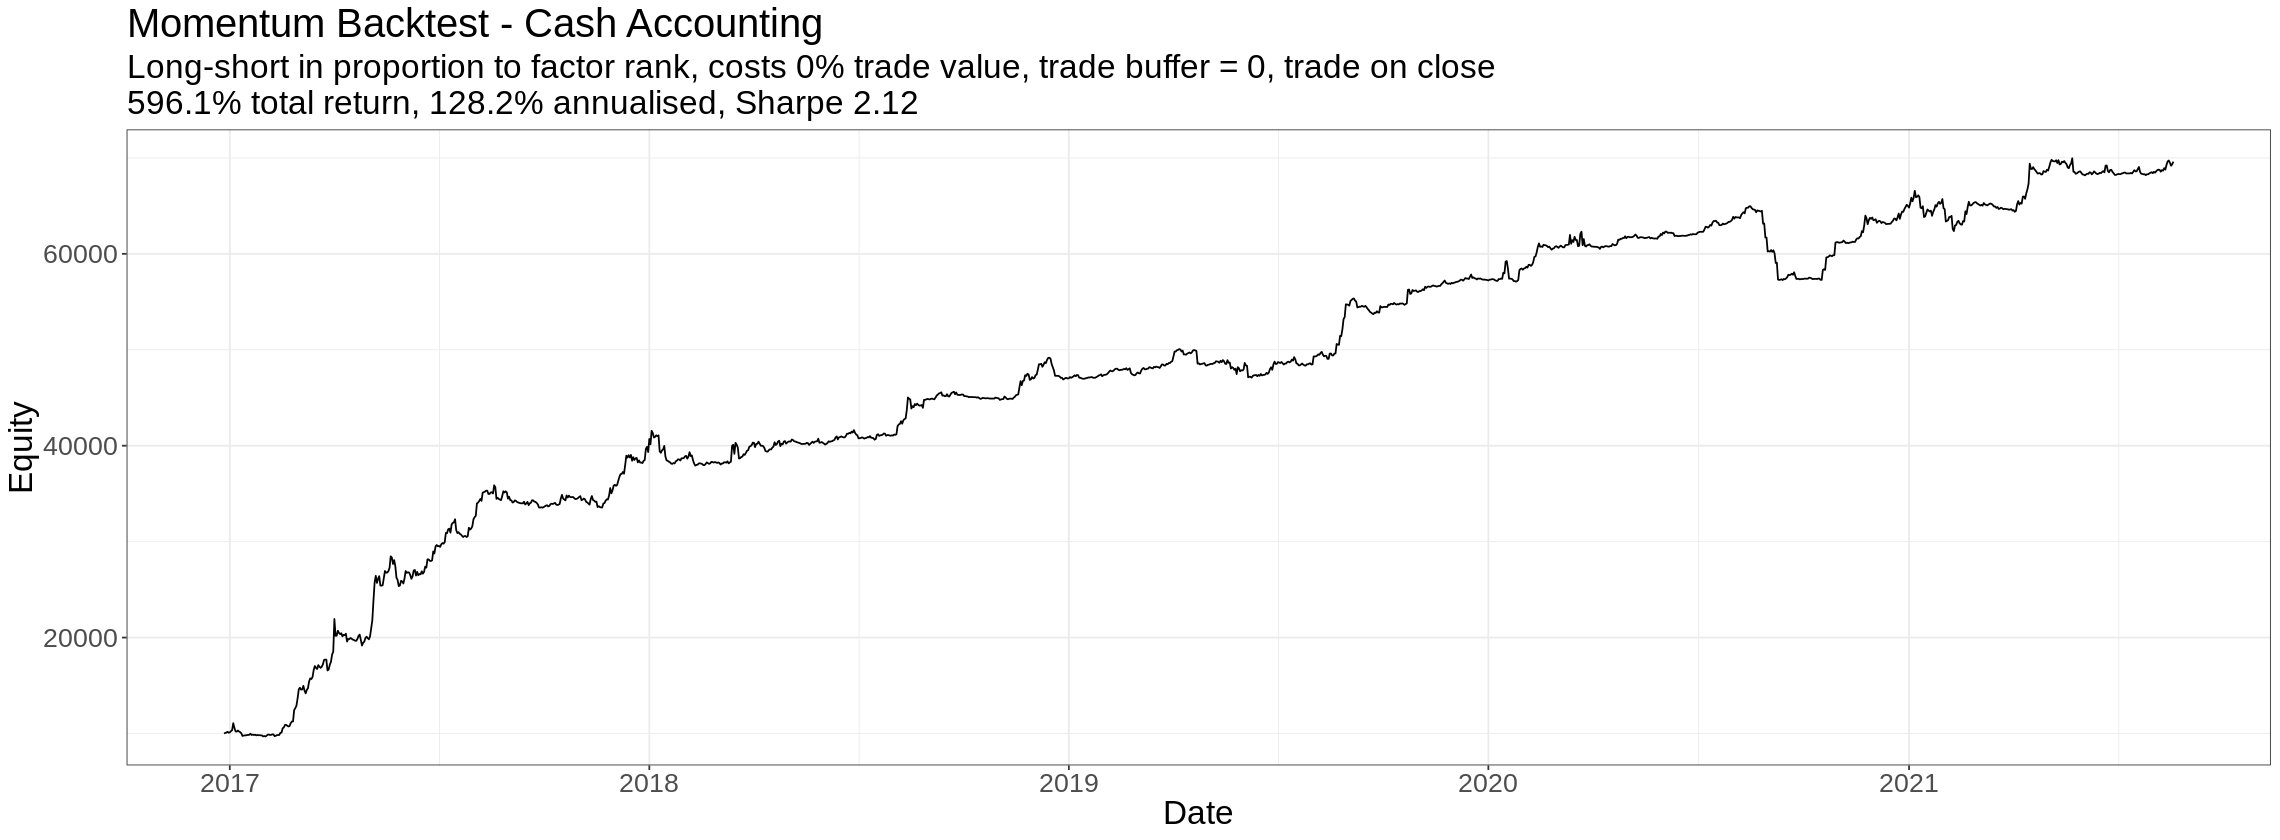

In [137]:
# simulation parameters
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.
fee_tier <- 0.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
results_df <- cash_backtest(backtest_prices, backtest_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits)
head(results_df)
plot_results(results_df)

With costs, no trade buffer parameter

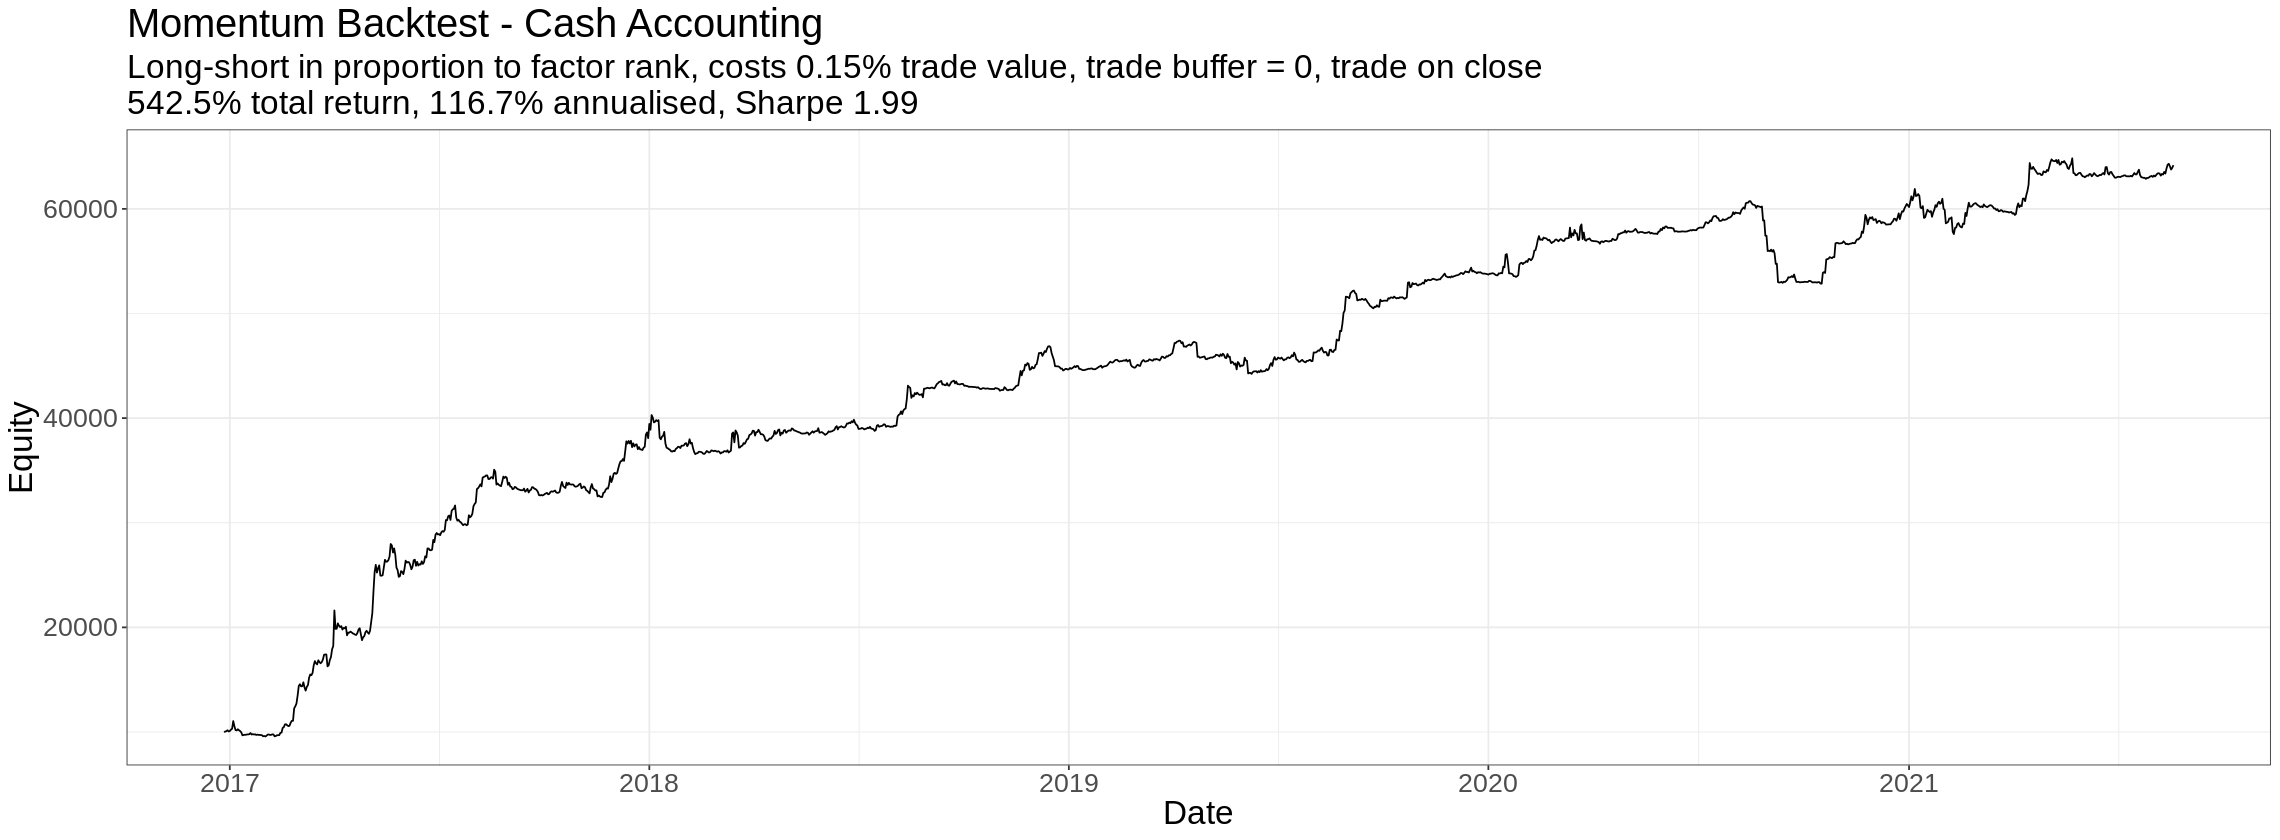

In [138]:
# simulation parameters
fee_tier <- 2.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
cash_backtest(
  backtest_prices, 
  backtest_weights, 
  trade_buffer, 
  initial_cash, 
  commission_pct, 
  capitalise_profits
) %>% 
  plot_results()


Find an appropriate trade buffer parameter by optimising for sharpe ratio

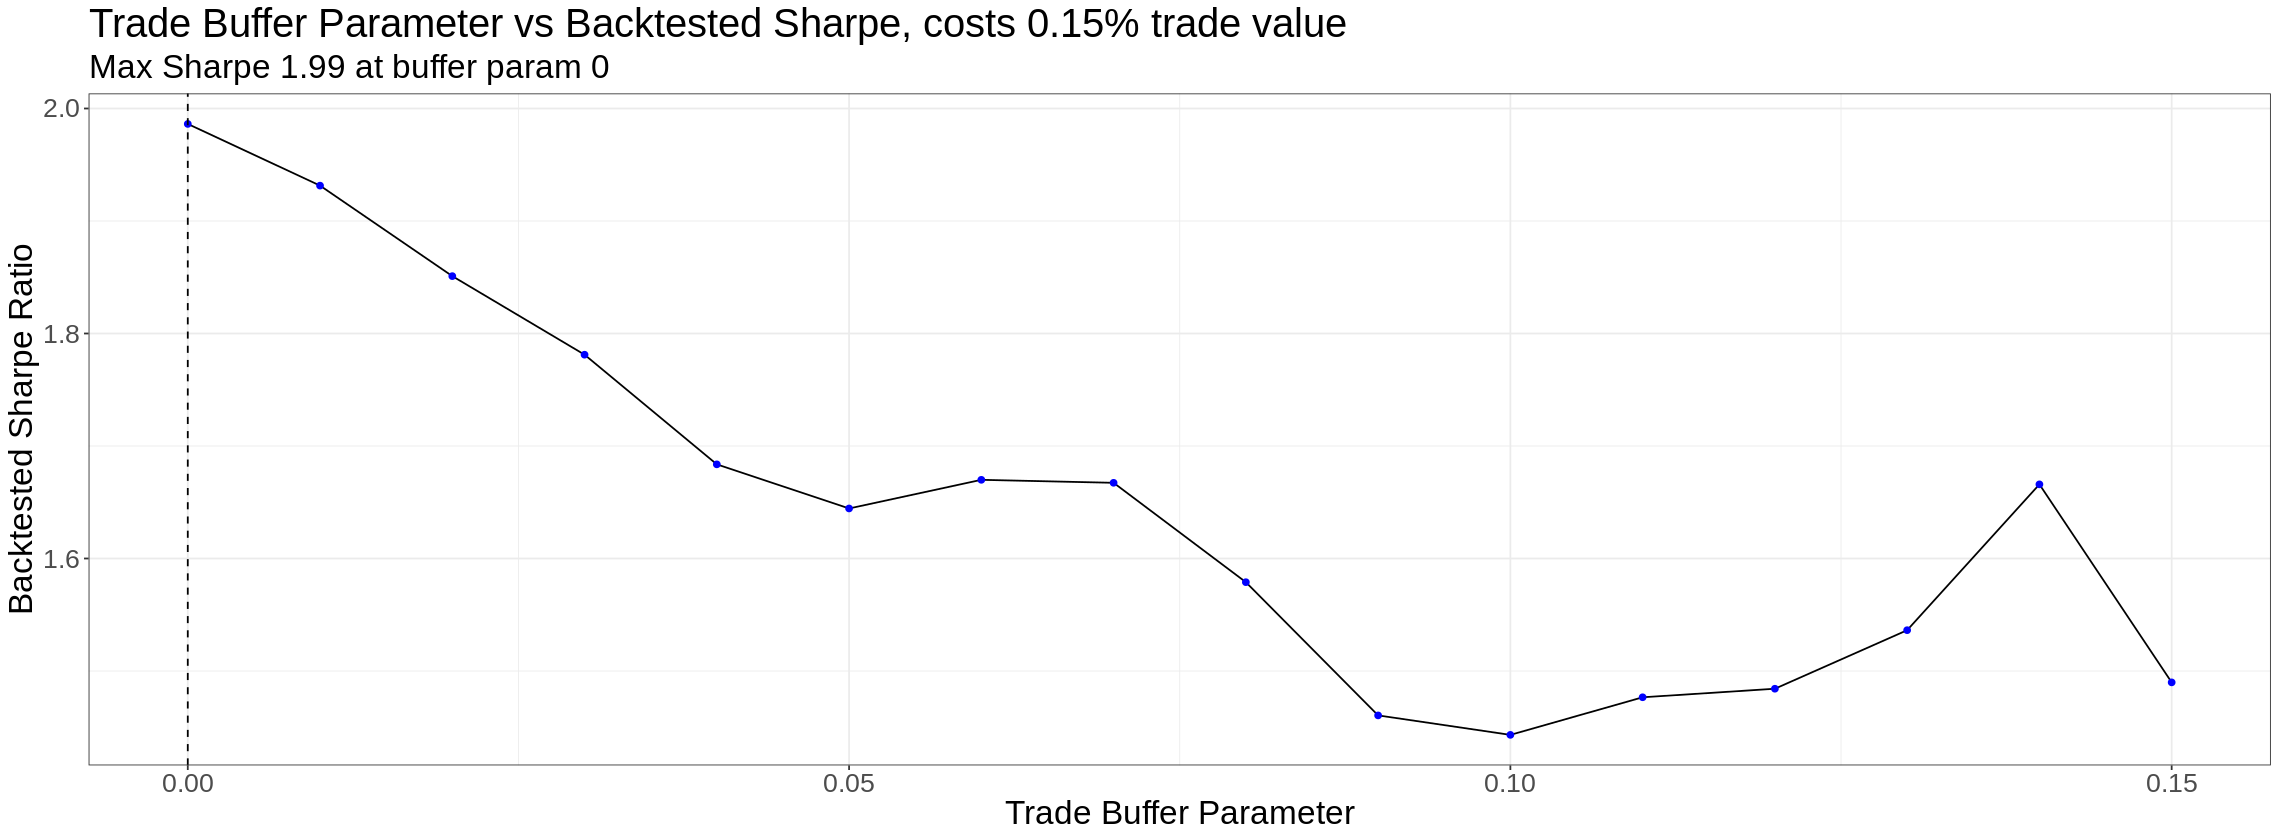

In [139]:
sharpes <- list()
trade_buffers <- seq(0, 0.15, by = 0.01)
for(trade_buffer in trade_buffers) {
  sharpes <- c(
    sharpes, 
    cash_backtest(
      backtest_prices, 
      backtest_weights, 
      trade_buffer, 
      initial_cash, 
      commission_pct, 
      capitalise_profits
    ) %>%
      calc_sharpe()
  )
}

sharpes <- unlist(sharpes)
data.frame(
  trade_buffer = trade_buffers, 
  sharpe = sharpes
) %>%
  ggplot(aes(x = trade_buffer, y = sharpe)) +
    geom_line() +
    geom_point(colour = "blue") +
    geom_vline(xintercept = trade_buffers[which.max(sharpes)], linetype = "dashed") +
    labs(
      x = "Trade Buffer Parameter",
      y = "Backtested Sharpe Ratio",
      title = glue("Trade Buffer Parameter vs Backtested Sharpe, costs {commission_pct*100}% trade value"),
      subtitle = glue("Max Sharpe {round(max(sharpes), 2)} at buffer param {trade_buffers[which.max(sharpes)]}")
    )

Backtest with optimal trade buffer


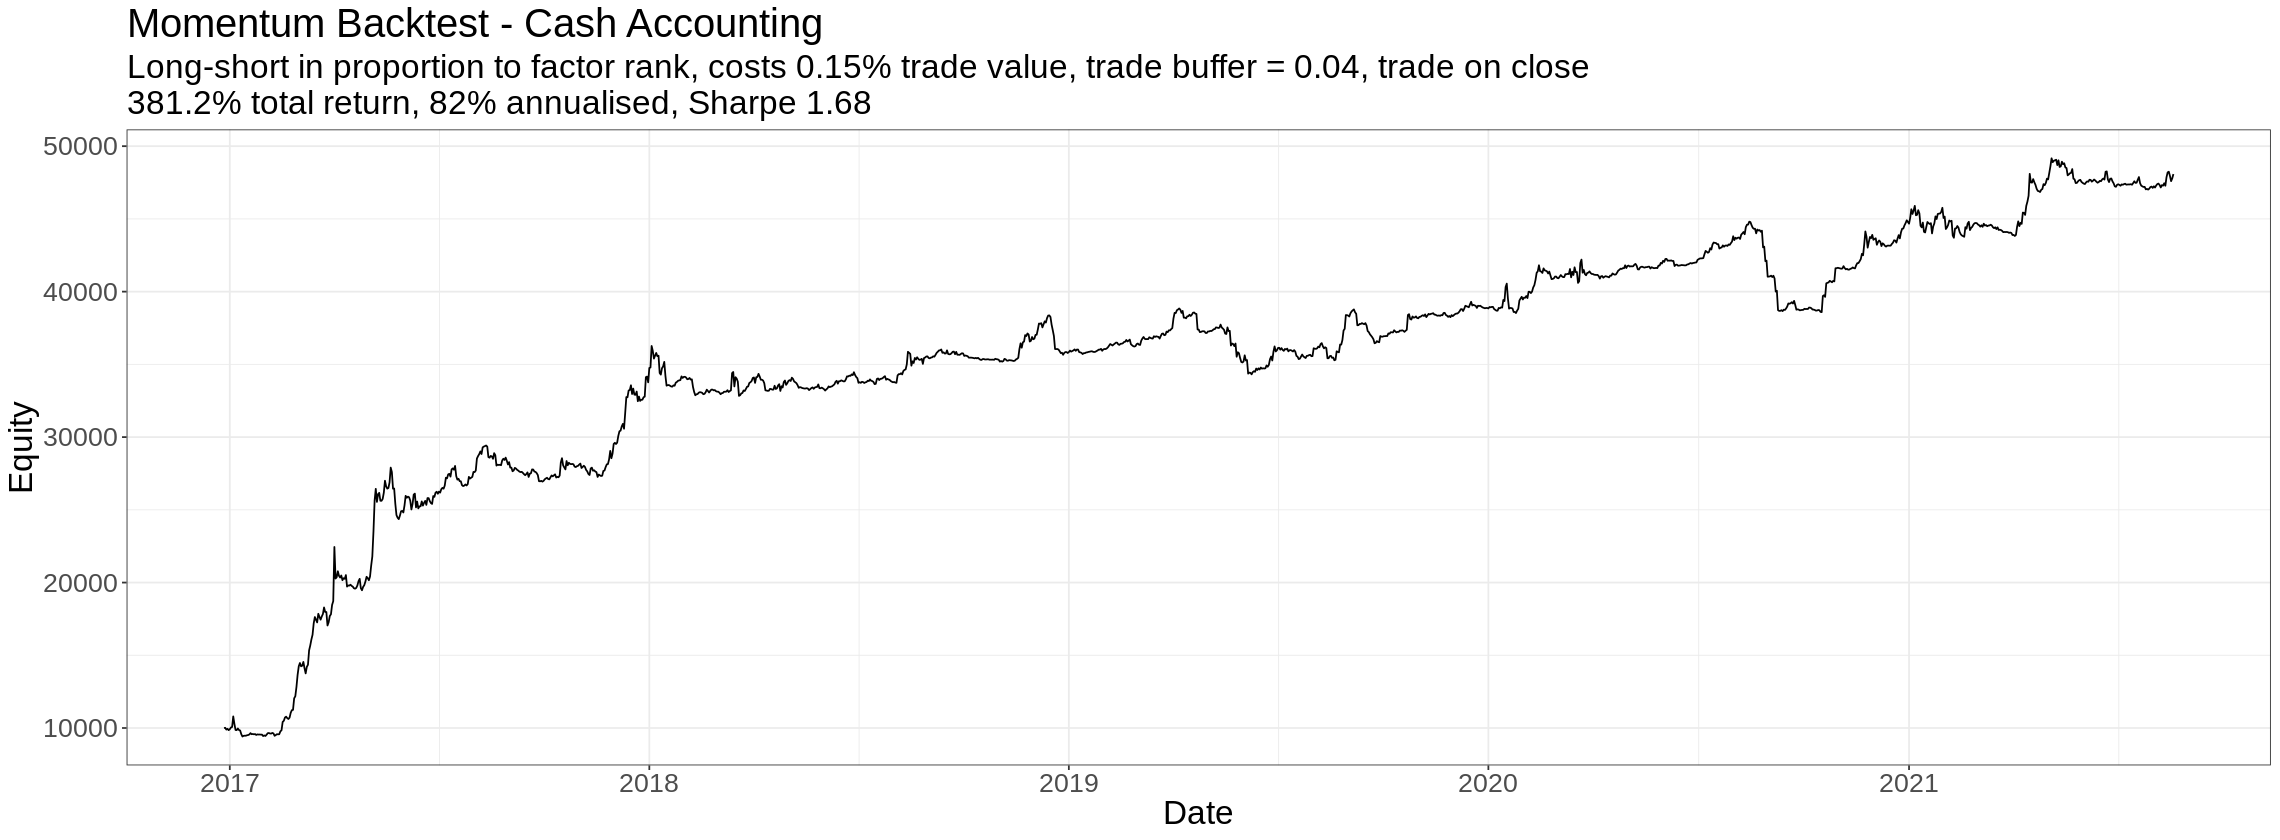

In [140]:
trade_buffer <- 0.04

cash_backtest(
  backtest_prices, 
  backtest_weights, 
  trade_buffer, 
  initial_cash, 
  commission_pct, 
  capitalise_profits
) %>% 
plot_results()

In [141]:
get_pnl <- function(backtest_results, weighting_protocol = "Long-short in proportion to factor rank", trade_on = "close") {
  equity_curve <- backtest_results %>% 
    group_by(Date) %>% 
    summarise(Equity = sum(Value, na.rm = TRUE)) 

  fin_eq <- equity_curve %>% 
    tail(1) %>% 
    pull(Equity)

  init_eq <- equity_curve %>% 
    head(1) %>% 
    pull(Equity)

  total_return <- (fin_eq/init_eq - 1) * 100
  days <- nrow(equity_curve)
  ann_return <- total_return * 365/days
  sharpe <- equity_curve %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(355)*mean(returns)/sd(returns)) %>%
    pull()

  return(equity_curve)
}

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



[1] 0.3899935

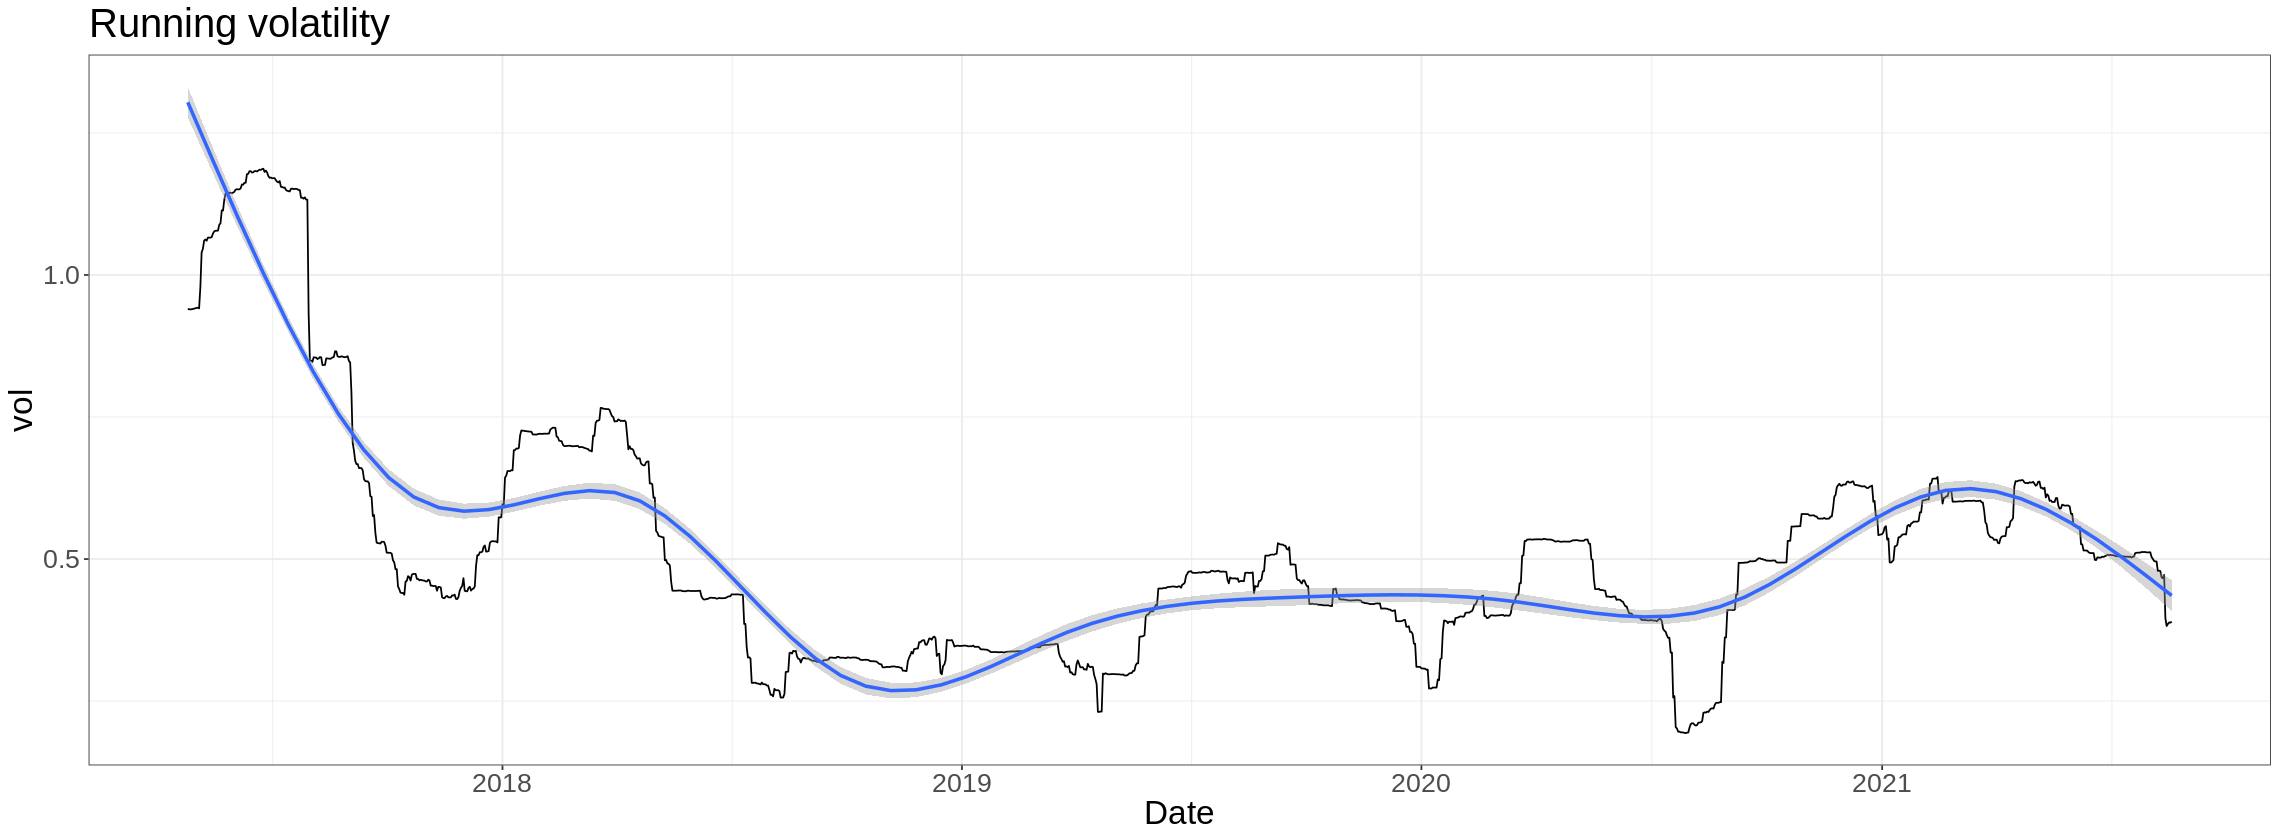

In [142]:
pnl <- cash_backtest(
  backtest_prices, 
  backtest_weights, 
  trade_buffer, 
  initial_cash, 
  commission_pct, 
  capitalise_profits) %>%
  get_pnl() %>%
  mutate(dailypnl = Equity-lag(Equity,1),
    vol = roll_sdr(dailypnl/10000, 120)*sqrt(365)) %>%
  na.omit()

pnl %>% ggplot(aes(x=Date, y=vol)) +
  geom_line() +
  geom_smooth() +
  ggtitle('Running volatility')
pnl %>% tail(1) %>% pull(vol)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Warning message:
“Removed 119 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 119 row(s) containing missing values (geom_path).”


[1] 9436.055

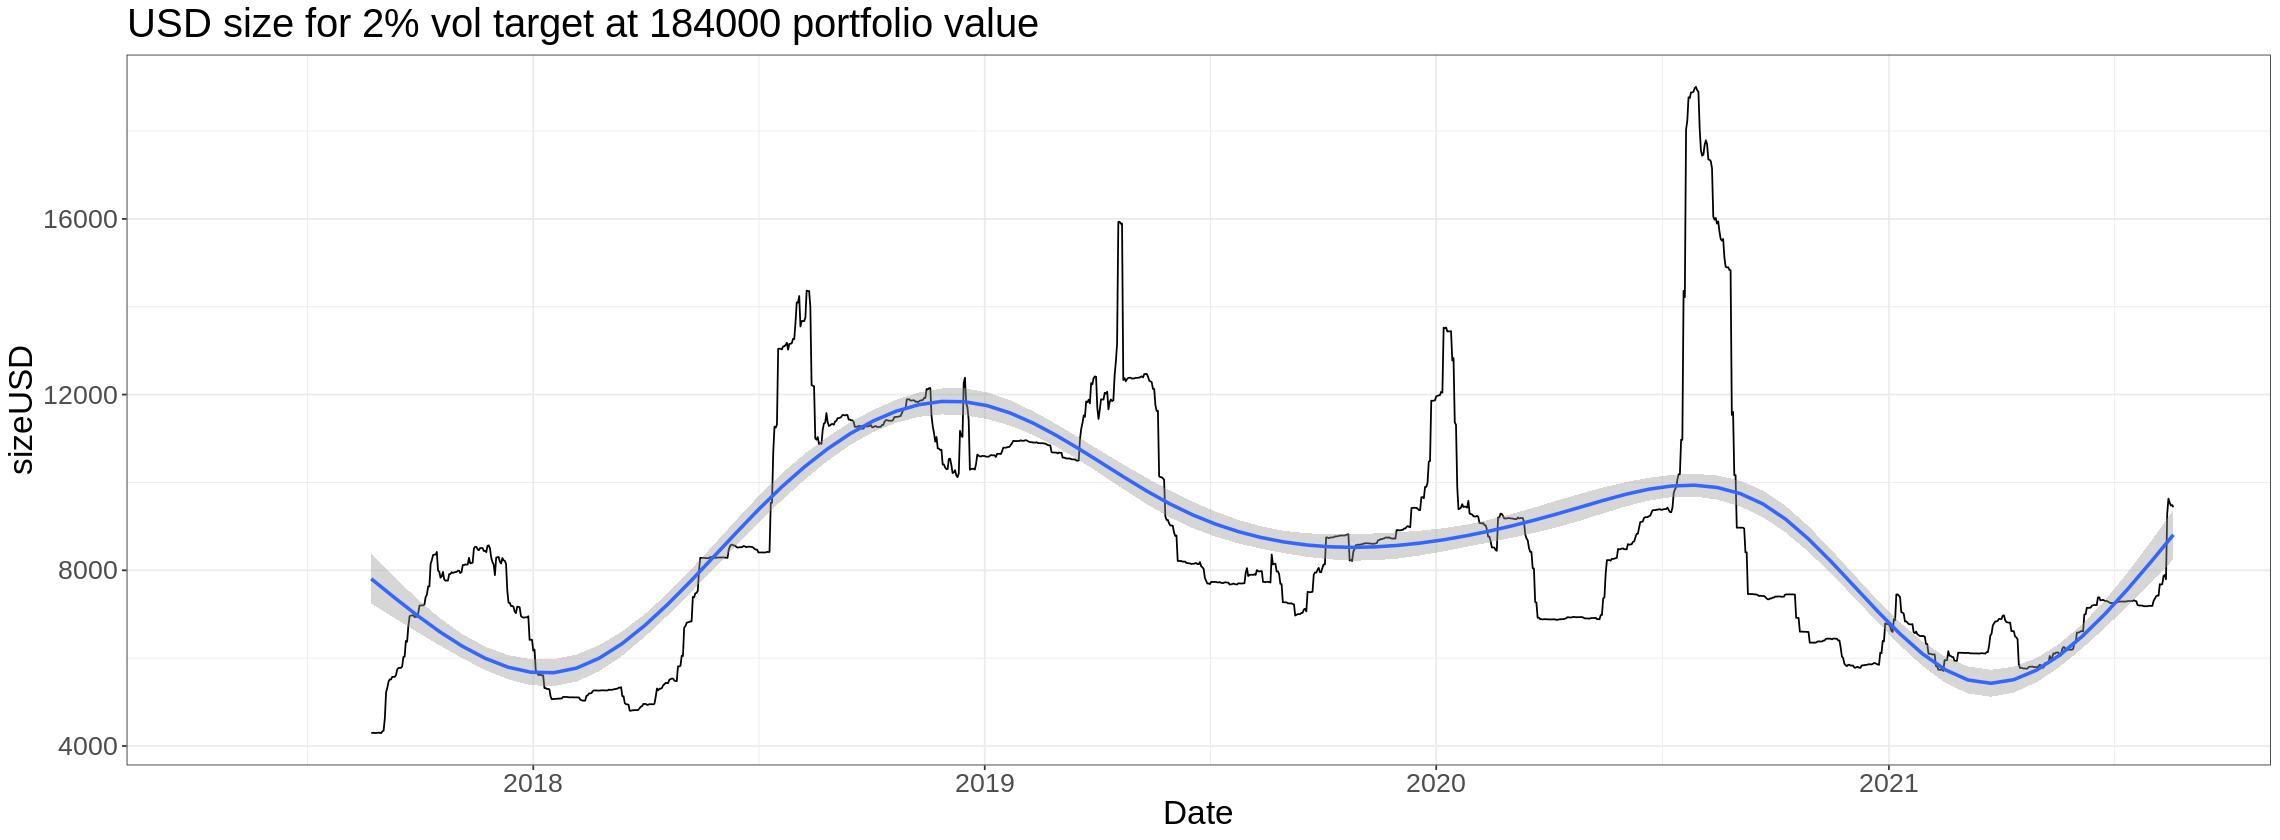

In [143]:
TotalPortfolioEquity <- 184000
vol_target <- 0.02

pnl <- pnl %>%
  mutate(portvol = roll_sdr(dailypnl/TotalPortfolioEquity, 120)*sqrt(365),
    sizeUSD = initial_cash*vol_target/portvol)

pnl %>% ggplot(aes(x=Date, y=sizeUSD)) +
  geom_line() +
  geom_smooth() +
  ggtitle(glue("USD size for {vol_target*100}% vol target at {TotalPortfolioEquity} portfolio value"))
pnl %>% tail(1) %>% pull(sizeUSD)

In [144]:
stratUSD <- 5000
final <- comboweight %>%
  select(date, ticker, combo_weight, price_usd) %>%
  mutate(assetUSD_low = (combo_weight-trade_buffer)*stratUSD,
    assetUSD_target = combo_weight*stratUSD,
    assetUSD_high = (combo_weight+trade_buffer)*stratUSD)


lastdate <- max(final$date)

final %>% filter(date == lastdate)

date,ticker,combo_weight,price_usd,assetUSD_low,assetUSD_target,assetUSD_high
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-08-19,ADA,0.157118817,2.419608e+00,585.59408,785.59408,985.59408
2021-08-19,BCH,0.005529139,6.580109e+02,-172.35430,27.64570,227.64570
2021-08-19,BTC,-0.023030117,4.664686e+04,-315.15058,-115.15058,84.84942
2021-08-19,DOGE,0.088169900,3.157983e-01,240.84950,440.84950,640.84950
2021-08-19,ETH,-0.034591594,3.173972e+03,-372.95797,-172.95797,27.04203
2021-08-19,LINK,0.017605758,2.689150e+01,-111.97121,88.02879,288.02879
2021-08-19,LTC,-0.012956949,1.749231e+02,-264.78474,-64.78474,135.21526
2021-08-19,UNI,-0.054138745,2.787822e+01,-470.69373,-270.69373,-70.69373
2021-08-19,XLM,0.035284284,3.662543e-01,-23.57858,176.42142,376.42142
